# Models and Feature Search
1. Try existing data on a simple MLP
2. Try VAE to get feature vectors
3. Compare performance






# 0. Load CSV and Labels to Process

In [3]:
# @title 0.0 Mount Drive (data quality assumed to have been check prior)

import sys
import os
import time
from google.colab import drive
import pandas as pd

# Define paths
DRIVE_PATH = '/content/gdrive'

ADIGE_PATH = os.path.join(DRIVE_PATH, 'MyDrive/Team 1 - Adige BLM/') # !NOTE: Create a shortcut of the shared-folder in your drive
BIN_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'database')
CSV_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'database_CSV')
CODING_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'coding')
LABEL_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'database_labels')

# Mount GDrive
try:
    # Set force_remount=True for reliability in Colab
    drive.mount(DRIVE_PATH, force_remount=True)
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    sys.exit(1)

# Wait briefly for mount
time.sleep(5)

# Check if the project directory exists
if os.path.exists(ADIGE_PATH):
    print(f"Project directory accessible at {ADIGE_PATH}\n")
else:
    print(f"Error: The project directory was not found at {ADIGE_PATH}")
    sys.exit(1)

Mounted at /content/gdrive
Project directory accessible at /content/gdrive/MyDrive/Team 1 - Adige BLM/



# 1. Import Data

In [4]:
# @title 1.0 Select which machine data to import
machine_name = "LT8A2200692"

In [6]:
# @title 1.1 Load X_array, y_pw_array, y_lens_array from the pickles
# For all feature in X and for both y, plot it in plotly as a stack of plots (add range slider)

import pickle
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Define path
pkl_path = os.path.join(CODING_PATH, 'restructured_data_V1', f'{machine_name}.pkl')

# 1. Load Data
print(f"Loading data from {pkl_path}...")
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)

X = data['X']
y_pw = data['y_pw']
y_lens = data['y_lens']
features = data['features']

print(f"Loaded X: {X.shape}")
print(f"Loaded y_pw: {y_pw.shape}")
print(f"Loaded y_lens: {y_lens.shape}")
print(f"Loaded features: {features}")



Loading data from /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/restructured_data_V1/LT8A2200692.pkl...
Loaded X: (12789, 1024, 10)
Loaded y_pw: (12789,)
Loaded y_lens: (12789,)
Loaded features: ['$AC_VACTW (mm/min)', 'Gas set pressure (0.01 bar)', 'Gas type', 'Bar material', 'Bar thickness', 'Pressure (0.01 bar)', 'Laser set power (W)', 'Temperature lens IR (0.01 °C)', 'Temperature window IR (0.01 °C)', 'Temperature window BTS (0.01 °C)']


In [ ]:
# @title 1.2 Plot X features and y labels

# 2. Prepare Data for Plotting
# X is (Samples, TimeSteps, Features).
# To visualize efficiently, we'll take the value at the LAST timestep of each segment
# This aligns with the timestamp of the label y.
plot = False
if plot:
  X_last_step = X[:, -1, :]

  # Create sample indices (0 to N-1)
  x_axis = np.arange(len(y_pw))

  # 3. Create Plotly Figure
  # Rows = Number of features + 2 labels
  num_features = len(features)
  total_rows = num_features + 2

  subplot_titles = features + ['Label: Poll PW', 'Label: Poll Lens']

  fig = make_subplots(
      rows=total_rows,
      cols=1,
      shared_xaxes=True,
      vertical_spacing=0.005,
      subplot_titles=subplot_titles
  )

  # Add Feature Traces
  for i, feature_name in enumerate(features):
      fig.add_trace(
          go.Scatter(
              x=x_axis,
              y=X_last_step[:, i],
              name=feature_name,
              mode='markers',
              marker=dict(size=3)
          ),
          row=i+1, col=1
      )

  # Add Label Traces
  # Poll PW
  fig.add_trace(
      go.Scatter(
          x=x_axis,
          y=y_pw,
          name='Poll PW',
          mode='markers',
          marker=dict(color='red', size=3)
      ),
      row=num_features + 1, col=1
  )

  # Poll Lens
  fig.add_trace(
      go.Scatter(
          x=x_axis,
          y=y_lens,
          name='Poll Lens',
          mode='markers',
          marker=dict(color='orange', size=3)
      ),
      row=num_features + 2, col=1
  )

  # 4. Layout Settings
  fig.update_layout(
      height=200 * total_rows,
      title=f"Feature Values (at segment end) vs Labels - {machine_name}",
      showlegend=False
  )

  # Add Range Slider to the bottom plot
  fig.update_xaxes(rangeslider=dict(visible=True), row=total_rows, col=1)

  fig.show()

In [7]:
# @title 1.3 Preprocess Data

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 1. Normalize X
# X shape is (Samples, TimeSteps, Features) -> (8793, 1024, 10),
# note how in a day there are multiple samples, which then continues to the next (day info is not considered anymore)
# We want to scale each Feature independently.
N, T, F = X.shape

# Flatten to (Total_TimeSteps, Features) to learn scaling parameters per feature
X_flat_features = X.reshape(-1, F)

scaler = StandardScaler()
X_scaled_flat = scaler.fit_transform(X_flat_features)

# Reshape back to (N, T, F) then flatten to (N, T*F) for MLP input
X_scaled = X_scaled_flat.reshape(N, T, F)
X_mlp_input = X_scaled.reshape(N, -1)  # Shape: (8793, 10240)

print(f"Processed X shape for MLP: {X_mlp_input.shape}")

# 2. Bin y_pw into 10 categories (0-100 range)
# Bins: 0-10, 10-20, ..., 90-100
# We clip to 0-99.99 before division to ensure 100 doesn't create an 11th class if present,
# or we can simply clip the resulting indices.
y_classes = np.floor(y_pw / 10).astype(int)
y_classes = np.clip(y_classes, 0, 9) # Ensure classes are 0-9

# One-hot encode
y_onehot = to_categorical(y_classes, num_classes=10)

print(f"Processed y shape: {y_onehot.shape}")
print(f"Sample classes: {y_classes[:10]}")

# 3. Split Data (90% Train, 10% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X_mlp_input, y_onehot, test_size=0.10, random_state=42, shuffle=True
)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

Processed X shape for MLP: (12789, 10240)
Processed y shape: (12789, 10)
Sample classes: [1 1 1 1 1 1 1 1 1 1]
Train shape: (11510, 10240), (11510, 10)
Test shape: (1279, 10240), (1279, 10)


# 2. Simple MLP

In [ ]:
# @title 2.1 Define and Train MLP

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 4. Define MLP Model
model = Sequential([
    # Input layer matches flattened dimension (1024 * 10)
    Dense(2*128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(2*64, activation='relu'),
    Dropout(0.1),
    Dense(1*32, activation='relu'),
    #Dropout(0.1),
    #Dense(2*16, activation='relu'),
    Dense(10, activation='softmax') # 10 Output categories
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 5. Train
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_split=0.1, # Validation within training set
    verbose=1
)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                │ (None, 256)            │     2,621,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,659,050 (10.14 MB)

 Trainable params: 2,659,050 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3365 - loss: 3.0212 - val_accuracy: 0.4811 - val_loss: 1.2634
Epoch 2/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4604 - loss: 1.3827 - val_accuracy: 0.4937 - val_loss: 1.1829
Epoch 3/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4901 - loss: 1.2533 - val_accuracy: 0.5328 - val_loss: 1.0512
Epoch 4/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5250 - loss: 1.1521 - val_accuracy: 0.5884 - val_loss: 0.9789
Epoch 5/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5518 - loss: 1.0674 - val_accuracy: 0.6086 - val_loss: 0.9688
Epoch 6/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5638 - loss: 1.0274 - val_accuracy: 0.6174 - val_loss: 0.9459
Epoch 7/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5921 - loss: 0.9836 - val_accuracy: 0.6098 - val_loss: 0.9483
Epoch 8/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5975 - loss: 0.9483 - 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7662 - loss: 0.5808

Test Accuracy: 75.80%


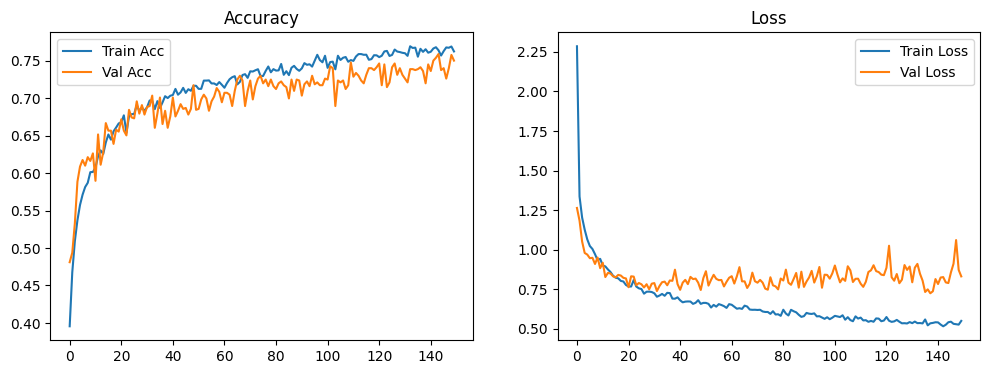

In [ ]:
# @title 2.2 Test MLP

# 6. Evaluate on Test Set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# 3. VAE + MLP

Define and train a Variational Autoencoder (VAE) to extract latent features from the flattened sensor data.

1.  **Define the VAE Architecture**:
    *   Create an `Encoder` that maps the input (shape `(10240,)`) to a latent space of dimension `1024` (calculating `z_mean` and `z_log_var`). Use a sampling layer (Reparameterization Trick).
    *   Create a `Decoder` that maps the latent vector back to the original input shape `(10240,)`.
    *   Combine them into a `VAE` model.

2.  **Compile and Train**:
    *   Define a custom loss function that sums the **reconstruction loss** (MSE between input and output) and the **KL divergence** (regularization term).
    *   Train the VAE using the existing `X_train` data (which is already flattened and scaled) for 50 epochs with a batch size of 64. Use `X_test` for validation.
    *   Visualize the training and validation loss.

In [ ]:
import numpy as np

# Check for NaNs before fixing
nan_train_before = np.isnan(X_train).any()
nan_test_before = np.isnan(X_test).any()

print(f"NaNs in X_train before fix: {nan_train_before}")
print(f"NaNs in X_test before fix: {nan_test_before}")

# Replace NaNs with 0.0 (mean value for standardized data)
# Also replacing infinity just in case
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

# Verify that no NaNs remain
nan_train_after = np.isnan(X_train).any()
nan_test_after = np.isnan(X_test).any()

print(f"NaNs in X_train after fix: {nan_train_after}")
print(f"NaNs in X_test after fix: {nan_test_after}")

if not nan_train_after and not nan_test_after:
    print("\nSuccess: All NaN values have been replaced with 0.0.")
else:
    print("\nWarning: NaN values are still present.")

NaNs in X_train before fix: False
NaNs in X_test before fix: False
NaNs in X_train after fix: False
NaNs in X_test after fix: False

Success: All NaN values have been replaced with 0.0.


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 1024), (None,  │     6,294,016 │
│                                 │ 1024), (None, 1024)]   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 10240)          │     5,777,920 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,071,936 (46.05 MB)

 Trainable params: 12,071,936 (46.05 MB)

 Non-trainable params: 0 (0.00 B)


Starting Stabilized VAE Training...
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 32s 240ms/step - loss: 82.9399 - val_loss: 11.3043
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 253ms/step - loss: 7.2854 - val_loss: 7.0828
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 33s 266ms/step - loss: 3.5875 - val_loss: 5.5900
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 244ms/step - loss: 2.5464 - val_loss: 5.0307
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 240ms/step - loss: 2.2279 - val_loss: 4.2998
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 264ms/step - loss: 1.9354 - val_loss: 4.2652
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 237ms/step - loss: 1.8696 - val_loss: 4.2862
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 238ms/step - loss: 1.6545 - val_loss: 3.8199
Epoch 9/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - loss: 1.6430 - val_loss: 3.7548
Epoch 10/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - loss: 1.5487 - val_loss: 3.8336
Epoch 11/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - loss: 1.6125

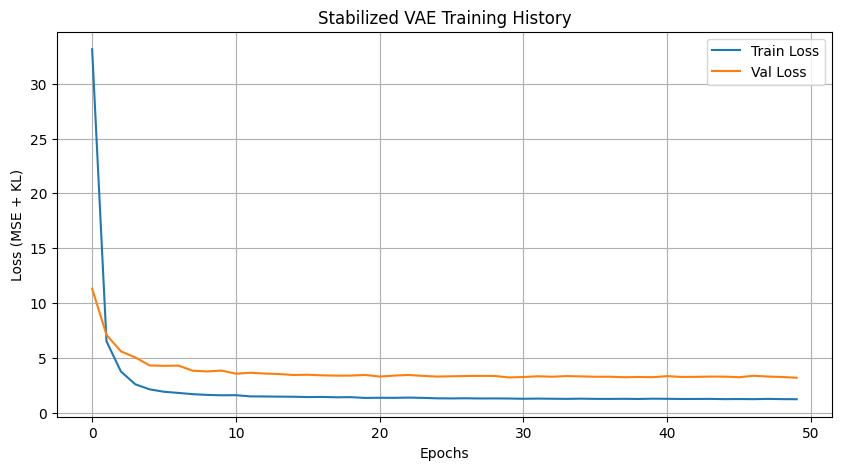

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Parameters
original_dim = 10240
latent_dim = 1024
intermediate_dim = 512

# 2. Re-define Custom Layer
class SamplingAndKLLoss(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        z = z_mean + K.exp(0.5 * z_log_var) * epsilon

        # KL Divergence
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        )
        self.add_loss(kl_loss)
        return z

# 3. Re-instantiate Models
# Encoder
encoder_inputs = layers.Input(shape=(original_dim,), name='encoder_input')
x = layers.Dense(intermediate_dim, activation='relu')(encoder_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = SamplingAndKLLoss()([z_mean, z_log_var])
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
decoder_outputs = layers.Dense(original_dim, activation='linear')(x)
decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')

# VAE
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, vae_outputs, name='vae')

# 4. Compile with Gradient Clipping and Lower LR
optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
vae.compile(optimizer=optimizer, loss='mse')

vae.summary()

# 5. Train
print("\nStarting Stabilized VAE Training...")
history_vae = vae.fit(
    X_train, X_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_test, X_test),
    verbose=1
)

# 6. Visualization
plt.figure(figsize=(10, 5))
plt.plot(history_vae.history['loss'], label='Train Loss')
plt.plot(history_vae.history['val_loss'], label='Val Loss')
plt.title('Stabilized VAE Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE + KL)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# @title 3.0 Extract Latent Features and Save
import os
import pickle

# 1. Extract Latent Features (z_mean)
# The encoder returns [z_mean, z_log_var, z]. We use z_mean as the stable feature representation.
print("Extracting latent features...")
z_train_all = encoder.predict(X_train, verbose=1)
z_test_all = encoder.predict(X_test, verbose=1)

# Extract just z_mean (index 0)
# Note: Depending on the Keras version/model definition, it might return a list or a single tensor if only one output was defined.
# Our encoder defines 3 outputs, so it will be a list.
z_train = z_train_all[0]
z_test = z_test_all[0]

print(f"Latent Train Shape: {z_train.shape}")
print(f"Latent Test Shape: {z_test.shape}")

# 2. Prepare Dictionary to Save
latent_data = {
    'X_train_latent': z_train,
    'X_test_latent': z_test,
    'y_train': y_train,
    'y_test': y_test
}

# 3. Save to Pickle
# Saving in the same directory as the input data, with a suffix.
save_path = os.path.join(CODING_PATH, 'restructured_data_V1', f'{machine_name}_latent_features.pkl')

print(f"Saving latent features to {save_path}...")
with open(save_path, 'wb') as f:
    pickle.dump(latent_data, f)

print("Done. Features saved.")

Extracting latent features...
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Latent Train Shape: (7913, 1024)
Latent Test Shape: (880, 1024)
Saving latent features to /content/gdrive/MyDrive/Team 1 - Adige BLM/restructured_data_V1/S0872101260506_latent_features.pkl...
Done. Features saved.


In [ ]:
# @title 3.1 Load Latent Features from Pickle

# Define path (same as where we saved it)
load_path = os.path.join(CODING_PATH, 'restructured_data_V1', f'{machine_name}_latent_features.pkl')

print(f"Loading latent features from {load_path}...")
with open(load_path, 'rb') as f:
    latent_data_loaded = pickle.load(f)

# Extract arrays
X_train_latent = latent_data_loaded['X_train_latent']
X_test_latent = latent_data_loaded['X_test_latent']
y_train = latent_data_loaded['y_train']
y_test = latent_data_loaded['y_test']

print(f"Loaded X_train_latent: {X_train_latent.shape}")
print(f"Loaded X_test_latent: {X_test_latent.shape}")
print(f"Loaded y_train: {y_train.shape}")
print(f"Loaded y_test: {y_test.shape}")

Loading latent features from /content/gdrive/MyDrive/Team 1 - Adige BLM/restructured_data_V1/S0872101260506_latent_features.pkl...
Loaded X_train_latent: (7913, 1024)
Loaded X_test_latent: (880, 1024)
Loaded y_train: (7913, 10)
Loaded y_test: (880, 10)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,378 (267.10 KB)

 Trainable params: 68,378 (267.10 KB)

 Non-trainable params: 0 (0.00 B)


Starting MLP Training on Latent Features...
Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.2183 - loss: 2.1580 - val_accuracy: 0.3043 - val_loss: 1.5877
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3217 - loss: 1.5726 - val_accuracy: 0.3043 - val_loss: 1.5095
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3208 - loss: 1.5189 - val_accuracy: 0.3283 - val_loss: 1.4946
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3263 - loss: 1.5005 - val_accuracy: 0.3283 - val_loss: 1.4812
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3498 - loss: 1.4754 - val_accuracy: 0.3169 - val_loss: 1.4623
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3413 - loss: 1.4701 - val_accuracy: 0.3346 - val_loss: 1.4293
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3478 - loss: 1.4442 - val_accuracy: 0.3611 - val_loss: 1.3997
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

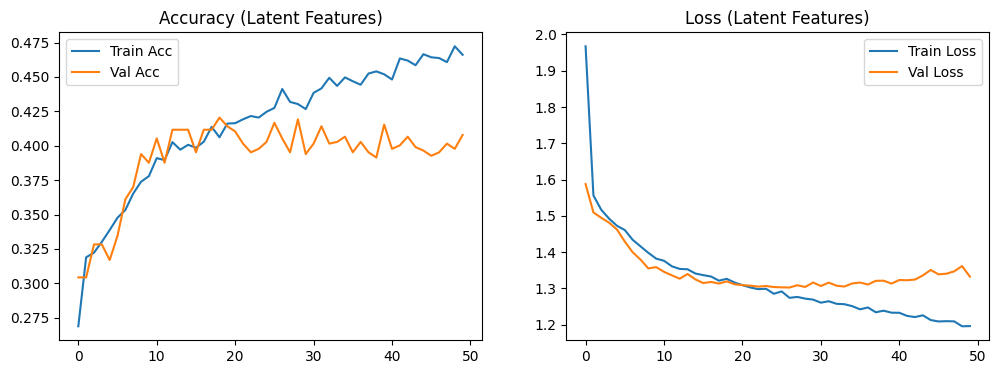

In [ ]:
# @title 3.2 Define and Train MLP on Latent Features

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# 1. Define MLP Model for Latent Features
# Input shape is now 1024 (latent_dim) instead of 10240
model_latent = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_latent.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(10, activation='softmax') # 10 Output categories
])

model_latent.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model_latent.summary()

# 2. Train
print("\nStarting MLP Training on Latent Features...")
history_latent = model_latent.fit(
    X_train_latent, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# 3. Evaluate
test_loss_latent, test_acc_latent = model_latent.evaluate(X_test_latent, y_test)
print(f"\nTest Accuracy (Latent Features): {test_acc_latent*100:.2f}%")

# 4. Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_latent.history['accuracy'], label='Train Acc')
plt.plot(history_latent.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy (Latent Features)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_latent.history['loss'], label='Train Loss')
plt.plot(history_latent.history['val_loss'], label='Val Loss')
plt.title('Loss (Latent Features)')
plt.legend()
plt.show()

# 4. Auto-encoder + MLP

In [ ]:
# @title 4.1 Define and Train Simple Autoencoder

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import os

# 1. Parameters
resume_training = False # Set to True to load previous best weights before training
original_dim = X_train.shape[1]  # Should be 10240
latent_dim = int(original_dim // 2   )

print(f"Input Dimension: {original_dim}")
print(f"Latent Dimension: {latent_dim}")

# 2. Define Autoencoder Architecture
# Encoder
input_img = Input(shape=(original_dim,))
# Add Dropout to make it a Denoising Autoencoder (robust to noise)
encoded_input = Dropout(0.2)(input_img)
encoded = Dense(latent_dim, activation='relu')(encoded_input)

# Decoder
decoded = Dense(original_dim, activation='linear')(encoded)

# Autoencoder Model
autoencoder = Model(input_img, decoded)

# Separate Encoder Model (for feature extraction later)
encoder_ae = Model(input_img, encoded)

# 3. Compile
# Added clipnorm to prevent gradient explosion
optimizer = Adam(learning_rate=1e-3, clipnorm=1.5)
autoencoder.compile(optimizer=optimizer, loss='mse')
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Define Callback to save the best model
checkpoint_path = os.path.join(CODING_PATH, 'models', f'{machine_name}_best_autoencoder.keras')
if not os.path.exists(os.path.dirname(checkpoint_path)):
    os.makedirs(os.path.dirname(checkpoint_path))

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Check if we should resume training
if resume_training and os.path.exists(checkpoint_path):
    print(f"\nResuming training: Loading weights from {checkpoint_path}...")
    autoencoder.load_weights(checkpoint_path)
else:
    print("\nStarting fresh training...")

# 4. Train
print("Starting Autoencoder Training...")
history_ae = autoencoder.fit(
    X_train, X_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_test, X_test),
    callbacks=[checkpoint],
    verbose=1
)

# Load the best weights (ensure we end with the best model, not just the last epoch)
print(f"Loading best weights from {checkpoint_path}...")
autoencoder.load_weights(checkpoint_path)

# 5. Visualization
plt.figure(figsize=(10, 5))
plt.plot(history_ae.history['loss'], label='Train Loss')
plt.plot(history_ae.history['val_loss'], label='Val Loss')
plt.title('Simple Autoencoder Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

Input Dimension: 10240
Latent Dimension: 5120


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5120)           │    52,433,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10240)          │    52,439,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,872,960 (400.06 MB)

 Trainable params: 104,872,960 (400.06 MB)

 Non-trainable params: 0 (0.00 B)


Starting fresh training...
Starting Autoencoder Training...
Epoch 1/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.4080
Epoch 1: val_loss improved from inf to 0.15274, saving model to /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/models/LT8A2200692_best_autoencoder.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - loss: 1.4036 - val_loss: 0.1527
Epoch 2/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1877
Epoch 2: val_loss improved from 0.15274 to 0.11808, saving model to /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/models/LT8A2200692_best_autoencoder.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 584s 3s/step - loss: 0.1877 - val_loss: 0.1181
Epoch 3/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1421
Epoch 3: val_loss improved from 0.11808 to 0.09670, saving model to /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/models/LT8A2200692_best_autoencoder.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 587s 3s/step - loss: 0.1421 - val_loss: 0.0967
Epoch 4/15
180/180 ━━━━━━━━━━━━━━━━━━

In [ ]:
# @title 4.2 Extract and Save AE Latent Features
import pickle

# 1. Extract Latent Features
print("Extracting latent features using AE...")
# The encoder_ae model maps Input -> Latent Layer
z_train_ae = encoder_ae.predict(X_train, verbose=1)
z_test_ae = encoder_ae.predict(X_test, verbose=1)

print(f"AE Latent Train Shape: {z_train_ae.shape}")
print(f"AE Latent Test Shape: {z_test_ae.shape}")

# 2. Prepare Dictionary to Save
latent_data_ae = {
    'X_train_latent': z_train_ae,
    'X_test_latent': z_test_ae,
    'y_train': y_train,
    'y_test': y_test
}

# 3. Save to Pickle
save_path_ae = os.path.join(CODING_PATH, 'restructured_data_V1', f'{machine_name}_ae_latent_features_clipped.pkl')

print(f"Saving AE latent features to {save_path_ae}...")
with open(save_path_ae, 'wb') as f:
    pickle.dump(latent_data_ae, f)

print("Done. Features saved.")

Extracting latent features using AE...
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
AE Latent Train Shape: (7913, 5120)
AE Latent Test Shape: (880, 5120)
Saving AE latent features to /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/restructured_data_V1/S0872101260506_ae_latent_features_clipped.pkl...
Done. Features saved.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_94 (Dense)                │ (None, 256)            │     1,310,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,348,330 (5.14 MB)

 Trainable params: 1,348,330 (5.14 MB)

 Non-trainable params: 0 (0.00 B)


Starting MLP Training on AE Latent Features...
Epoch 1/200
109/112 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3904 - loss: 1.6402
Epoch 1: val_accuracy improved from -inf to 0.59848, saving model to /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/models/best_ae_mlp_model.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3926 - loss: 1.6312 - val_accuracy: 0.5985 - val_loss: 1.0407
Epoch 2/200
108/112 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5425 - loss: 1.0905
Epoch 2: val_accuracy did not improve from 0.59848
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5431 - loss: 1.0894 - val_accuracy: 0.5884 - val_loss: 0.9549
Epoch 3/200
109/112 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5899 - loss: 0.9931
Epoch 3: val_accuracy improved from 0.59848 to 0.61995, saving model to /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/models/best_ae_mlp_model.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5899 - loss: 0.9928 - val_accuracy: 0.6199 - 

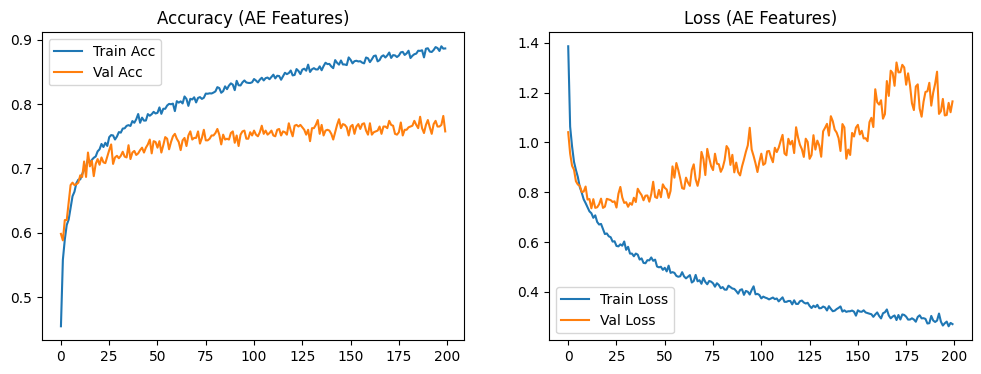

In [ ]:
# @title 4.3 Train MLP and Evaluate on AE Latent Features
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import os

# Define checkpoint path for saving the best model
checkpoint_path_ae_mlp = os.path.join(CODING_PATH, 'models', f'{machine_name}_best_ae_mlp_model.keras')
if not os.path.exists(os.path.dirname(checkpoint_path_ae_mlp)):
    os.makedirs(os.path.dirname(checkpoint_path_ae_mlp))

checkpoint_ae_mlp = ModelCheckpoint(
    checkpoint_path_ae_mlp,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# 1. Define MLP Model for AE Latent Features
# Input shape is latent_dim
model_ae_mlp = Sequential([
    Dense(2*128, activation='relu', input_shape=(z_train_ae.shape[1],)), # Reduced first layer size relative to input
    Dropout(0.3),
    Dense(2*64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

model_ae_mlp.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model_ae_mlp.summary()

# 2. Train
print("\nStarting MLP Training on AE Latent Features...")
history_ae_mlp = model_ae_mlp.fit(
    z_train_ae, y_train,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    callbacks=[checkpoint_ae_mlp], # Add the ModelCheckpoint callback
    verbose=1
)

# Load the best weights saved by the checkpoint
print(f"\nLoading best weights from {checkpoint_path_ae_mlp} for evaluation...")
model_ae_mlp.load_weights(checkpoint_path_ae_mlp)

# 3. Evaluate
test_loss_ae, test_acc_ae = model_ae_mlp.evaluate(z_test_ae, y_test)
print(f"\nTest Accuracy (AE Latent Features): {test_acc_ae*100:.2f}%")

# 4. Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ae_mlp.history['accuracy'], label='Train Acc')
plt.plot(history_ae_mlp.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy (AE Features)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ae_mlp.history['loss'], label='Train Loss')
plt.plot(history_ae_mlp.history['val_loss'], label='Val Loss')
plt.title('Loss (AE Features)')
plt.legend()
plt.show()

# Everything below is scratch work